*** Q ***

1

in A_zwickau there is some strange text that looks like: 

Beatus venter Ante portam orientalem civitatis ad iactum 2 sagittarum in arena ostenditur locus predicationis Ihesu Christi, ubi extulit vocem mulier de turba, d[icens]

need to understand what is meanin of \[ and how proceed this kind of words

2 

There is usage „Beatus venter“ VS “Beatus venter qui te portavit et ubera que succisti,” should be escaped or considered as punctuation usage?

In [61]:
# some manual processing that i did on text:
# convert docx to txt format
# remove footer from txt file
# remove header in english from txt file

import os
import re
import json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import cltk.alphabet.lat as latAlphabet
import cltk.lemmatize.lat as latLemmatize

In [24]:
%pip install cltk

Note: you may need to restart the kernel to use updated packages.


In [62]:
A_ZWICKAU_FILE_NAME = "A_Zwickau_RB_I_XII_5 (12).txt"
B_LONDON_FILE_NAME = "B_London_BL_Add_18929 (6).txt"
STOP_WORDS_FILE_NAME = "stop_words.json"

a_zwickau_file_path = os.path.join("full", A_ZWICKAU_FILE_NAME)
b_london_file_path = os.path.join("full", B_LONDON_FILE_NAME)
stop_words_file_path = os.path.join("full", STOP_WORDS_FILE_NAME)

a_zwickau_text = open(a_zwickau_file_path).read()
b_london_text = open(b_london_file_path).read()

stop_words = json.load(open(stop_words_file_path))

In [63]:
def jvtext(text):
    replacer = latAlphabet.JVReplacer()
    return replacer.replace(text)

In [64]:
def lemmatize(tokens):
    lemmatizer = latLemmatize.LatinBackoffLemmatizer()
    return lemmatizer.lemmatize(tokens)

def create_lemmatized_tokens(tokens):
    lemmatized = lemmatize(tokens)
    result = set()
    for l in lemmatized:
        result.add(l[1])
    return result

In [65]:
def create_corpus(raw_text):
    return [
        t.strip()
        .replace("„", "")
        .replace("“", "")
        .replace(".", "")
        .replace("?", "")
        .replace("‘","")
        .replace("’", "")
        .replace(":", "")
        .replace(";", "")
        .replace(",", "")
        .replace("  ", " ") for t in raw_text.lower().split("\n")]

In [66]:
# print(a_zwickau_text)
a_zwickau_corpus = create_corpus(jvtext(a_zwickau_text))
b_london_corpus = create_corpus(jvtext(b_london_text))

In [67]:
def get_lexical_features(corpus):
    text = ' '.join(corpus)
    
    total_characters = len(text)
    total_words = len(text.split())
    unique_words = len(set(text.split()))
    unique_lemmatized_word = len(create_lemmatized_tokens(text.split()))
    paragraphs = len(corpus)
    
    return total_characters, total_words, unique_words, paragraphs, unique_lemmatized_word

In [68]:
def create_lexical_features_df(text, label):
    df = pd.DataFrame(dtype=float)
    total_characters, total_words, unique_words, paragraphs, unique_lemmatized_word = get_lexical_features(text)
    
    df.loc[label, 'total_characters'] = total_characters
    df.loc[label, 'total_words'] = total_words
    df.loc[label, 'unique_words'] = unique_words
    df.loc[label, 'paragraphs'] = paragraphs
    df.loc[label, 'unique_lemmatized_word'] = unique_lemmatized_word
    
    return df

,total_characters,total_words,unique_words,paragraphs,unique_lemmatized_word
A_Zwickau_RB_I_XII_5,174212.0,27395.0,6388.0,321.0,4305.0
B_London_BL_Add_18929,194152.0,30586.0,6817.0,317.0,4478.0


<AxesSubplot:>

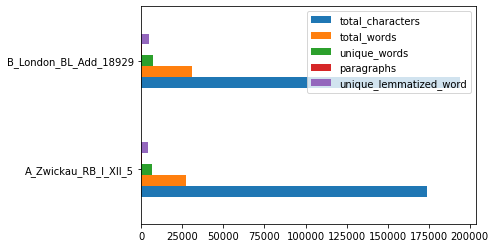

In [69]:
lexical_features_df = pd.concat([
    create_lexical_features_df(a_zwickau_corpus, "A_Zwickau_RB_I_XII_5"), 
    create_lexical_features_df(b_london_corpus, "B_London_BL_Add_18929")
])

display(lexical_features_df)
lexical_features_df.plot(kind="barh")

In [72]:
# here is neat graph for count: https://www.absentdata.com/python-graphs/python-word-frequency/
def create_words_frequency(corpus):    
    word_counter =  Counter(' '.join(corpus).split())
    return sorted(word_counter.items(), key=lambda item: item[1], reverse=True)

In [73]:
create_words_frequency(a_zwickau_corpus)[:10]

[('et', 1521),
 ('in', 1038),
 ('est', 600),
 ('de', 459),
 ('ad', 426),
 ('que', 263),
 ('quod', 247),
 ('per', 224),
 ('sunt', 215),
 ('contra', 198)]

In [74]:
create_words_frequency(b_london_corpus)[:10]

[('et', 1685),
 ('in', 1149),
 ('est', 668),
 ('de', 531),
 ('ad', 441),
 ('quod', 273),
 ('que', 260),
 ('per', 258),
 ('contra', 247),
 ('sunt', 228)]

In [75]:
def create_bag_of_words_by_paragraph(corpus):
    tokenizer = RegexpTokenizer(r'\w+|$[0-9.]+|\S+')
    bag_of_words_by_paragpaph = {}
    for i, sentence in enumerate(corpus):
        tokens = tokenizer.tokenize(sentence)
        bag_of_words_by_paragpaph[i] = dict((tok, 1) for tok in tokens)
    return bag_of_words_by_paragpaph


In [76]:
a_zwickau_bag_of_words = create_bag_of_words_by_paragraph(a_zwickau_corpus)
b_london_bag_of_words = create_bag_of_words_by_paragraph(b_london_corpus)

a_zwickau_bag_of_words_df = pd.DataFrame.from_records(a_zwickau_bag_of_words).fillna(0).astype(int).T
b_london_bag_of_words_df = pd.DataFrame.from_records(b_london_bag_of_words).fillna(0).astype(int).T

In [77]:
def calculate_bag_of_words_overlap(df):
    paragrapns_amount = len(df.index) - 1
    overlaps = np.empty([paragrapns_amount + 1, paragrapns_amount + 1])
    
    for passNo in range(paragrapns_amount, -1, -1):
        overlaps[passNo][passNo] = 0
        for idx in range(passNo):
            dot_product = df.iloc[passNo].dot(df.iloc[idx])
            overlaps[passNo][idx] = overlaps[idx][passNo] = dot_product
    
    return overlaps

In [78]:
a_zwickau_bag_of_words_overlap = calculate_bag_of_words_overlap(a_zwickau_bag_of_words_df)
b_london_bag_of_words_overlap = calculate_bag_of_words_overlap(b_london_bag_of_words_df)

a_zwickau_bag_of_words_overlap_df = pd.DataFrame.from_records(a_zwickau_bag_of_words_overlap).fillna(0).astype(int).T
b_london_bag_of_words_overlap_df = pd.DataFrame.from_records(b_london_bag_of_words_overlap).fillna(0).astype(int).T

In [79]:
a_zwickau_bag_of_words_overlap_describe = a_zwickau_bag_of_words_overlap_df.describe()
b_london_bag_of_words_overlap_describe = b_london_bag_of_words_overlap_df.describe()

In [80]:
b_london_bag_of_words_overlap_describe

,0,1,2,3,4,5,6,7,8,9,...,307,308,309,310,311,312,313,314,315,316
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,...,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,0.996845,6.842271,5.129338,6.148265,5.328076,10.542587,9.457413,9.536278,7.656151,11.085174,...,13.211356,7.930599,13.864353,9.902208,8.227129,16.164038,12.283912,10.615142,6.116719,9.643533
std,0.718201,3.499599,2.128541,3.256946,2.533247,4.744976,4.619947,4.611774,3.787688,5.380079,...,6.633927,3.213142,6.919786,4.363967,3.936862,8.118090,5.588881,4.883143,2.878709,4.571762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,4.000000,4.000000,4.000000,7.000000,6.000000,6.000000,5.000000,7.000000,...,8.000000,6.000000,9.000000,7.000000,5.000000,10.000000,8.000000,7.000000,4.000000,6.000000
50%,1.000000,6.000000,5.000000,6.000000,5.000000,10.000000,9.000000,9.000000,7.000000,10.000000,...,12.000000,8.000000,13.000000,9.000000,8.000000,15.000000,11.000000,10.000000,6.000000,9.000000
75%,1.000000,9.000000,7.000000,8.000000,7.000000,14.000000,12.000000,12.000000,10.000000,14.000000,...,17.000000,10.000000,17.000000,13.000000,10.000000,21.000000,16.000000,13.000000,8.000000,12.000000
max,3.000000,17.000000,10.000000,19.000000,13.000000,28.000000,24.000000,23.000000,20.000000,31.000000,...,46.000000,23.000000,45.000000,28.000000,25.000000,53.000000,35.000000,35.000000,19.000000,27.000000


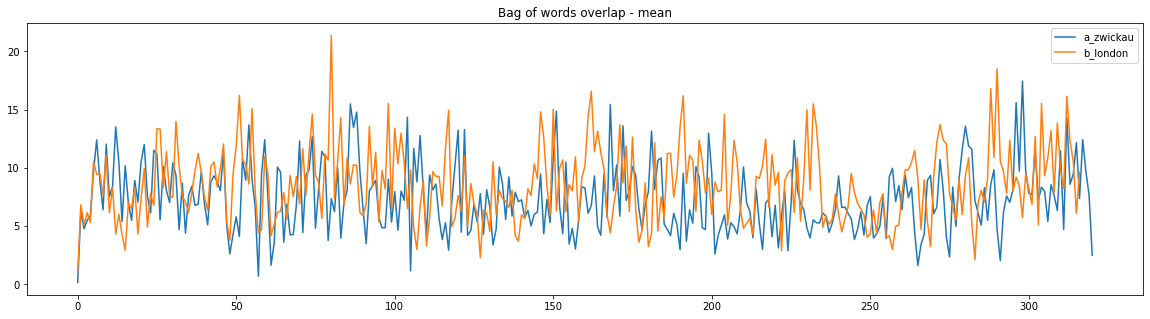

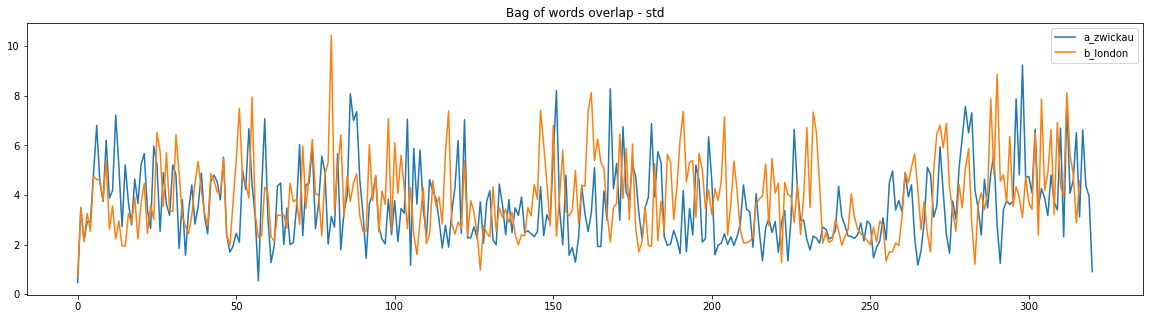

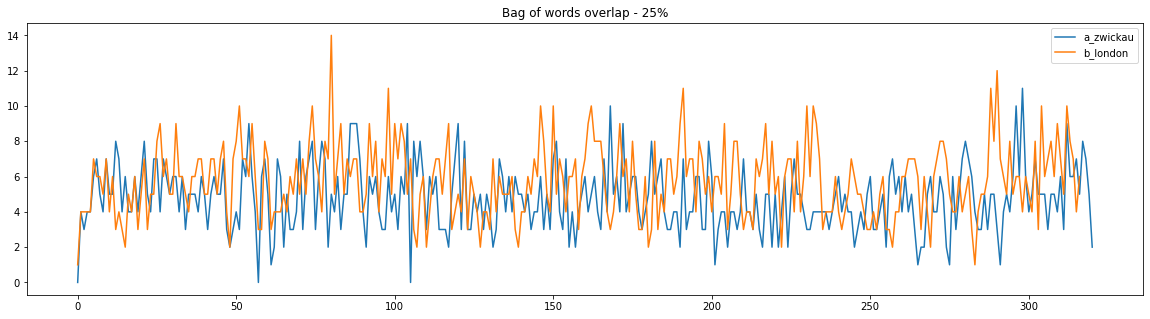

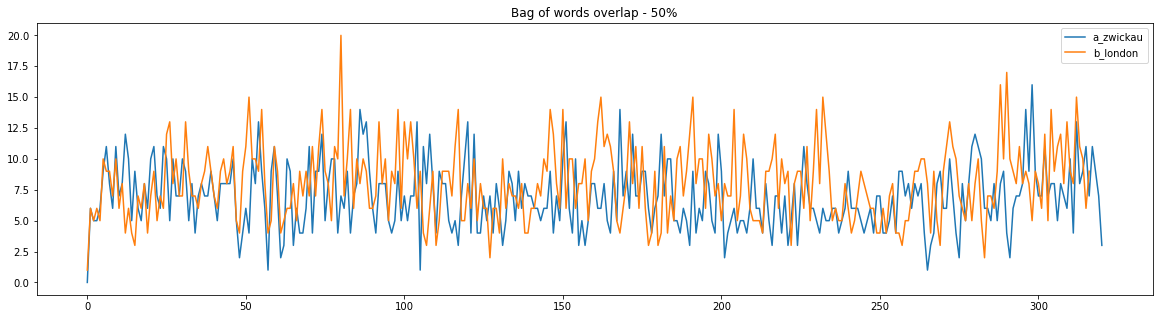

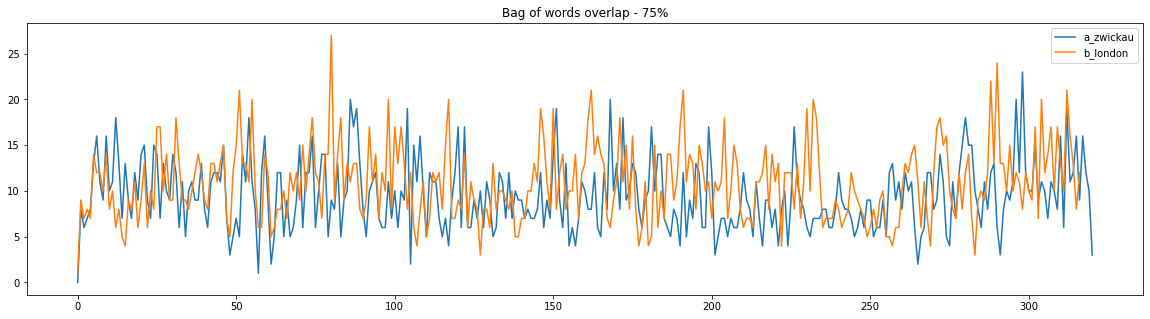

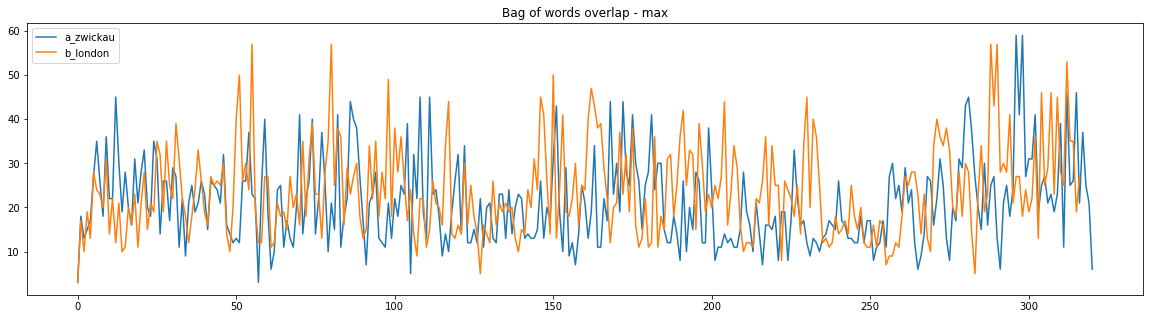

In [81]:
for param in ["mean", "std", "25%", "50%", "75%", "max"]:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(a_zwickau_bag_of_words_overlap_describe.loc[param, :], label="a_zwickau")
    ax.plot(b_london_bag_of_words_overlap_describe.loc[param, :], label="b_london")
    ax.legend()
    plt.title('Bag of words overlap - {}'.format(param))
    plt.show()

In [82]:
def calculate_n_gram_freq_per_paragraph(corpus, n_gram_val):
    cv = CountVectorizer(ngram_range=(n_gram_val, n_gram_val)).fit(corpus)
    return cv.transform(corpus).toarray()

In [83]:
a_zwickau_2_gram_freq = calculate_n_gram_freq_per_paragraph(a_zwickau_corpus, 2)
a_zwickau_3_gram_freq = calculate_n_gram_freq_per_paragraph(a_zwickau_corpus, 3)
a_zwickau_4_gram_freq = calculate_n_gram_freq_per_paragraph(a_zwickau_corpus, 4)

b_london_2_gram_freq = calculate_n_gram_freq_per_paragraph(b_london_corpus, 2)
b_london_3_gram_freq = calculate_n_gram_freq_per_paragraph(b_london_corpus, 3)
b_london_4_gram_freq = calculate_n_gram_freq_per_paragraph(b_london_corpus, 4)

In [84]:
print("a_zwickau_2_gram_freq: " + str(a_zwickau_2_gram_freq.shape))
print("a_zwickau_3_gram_freq: " + str(a_zwickau_3_gram_freq.shape))
print("a_zwickau_4_gram_freq: " + str(a_zwickau_4_gram_freq.shape))

a_zwickau_2_gram_freq: (321, 20519)
a_zwickau_3_gram_freq: (321, 25022)
a_zwickau_4_gram_freq: (321, 25678)


In [85]:
print("b_london_2_gram_freq: " + str(b_london_2_gram_freq.shape))
print("b_london_2_gram_freq: " + str(b_london_2_gram_freq.shape))
print("b_london_2_gram_freq: " + str(b_london_2_gram_freq.shape))

b_london_2_gram_freq: (317, 22696)
b_london_2_gram_freq: (317, 22696)
b_london_2_gram_freq: (317, 22696)


In [86]:
def calculate_cosine_similarities(gram_frequency):
    paragraphs_amount = len(gram_frequency) - 1
    cosine_similarities = np.empty([paragraphs_amount + 1, paragraphs_amount + 1])

    for passNo in range(paragraphs_amount, -1, -1):
        cosine_similarities[passNo][passNo] = 1
        for idx in range(passNo):
            cs = cosine_similarity(gram_frequency[passNo].reshape(1, -1), gram_frequency[idx].reshape(1, -1))[0][0]
            cosine_similarities[passNo][idx] = cosine_similarities[idx][passNo] = cs
    return cosine_similarities

In [87]:
def calculate_cosine_similarities_average(cosine_similarities):
    average = []
    for i, cs in enumerate(cosine_similarities):
        average.insert(i, np.average(cs))
    return average

In [88]:
a_zwickau_cosine_similarities = calculate_cosine_similarities(a_zwickau_2_gram_freq)
b_london_cosine_similarities = calculate_cosine_similarities(b_london_2_gram_freq)

a_zwickau_cosine_similarities_average = calculate_cosine_similarities_average(a_zwickau_cosine_similarities)
b_london_cosine_similarities_average = calculate_cosine_similarities_average(b_london_cosine_similarities)

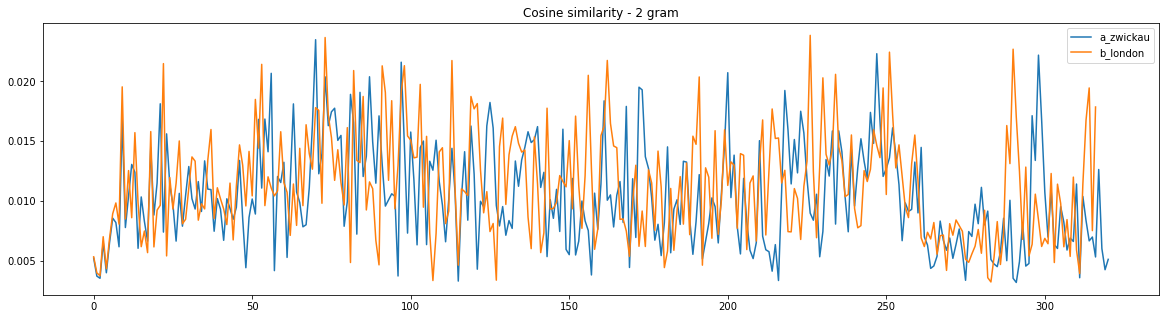

In [89]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(a_zwickau_cosine_similarities_average, label="a_zwickau")
ax.plot(b_london_cosine_similarities_average, label="b_london")
ax.legend()
plt.title('Cosine similarity - 2 gram'.format(param))
plt.show()

In [90]:
a_zwickau_cosine_similarities = calculate_cosine_similarities(a_zwickau_3_gram_freq)
b_london_cosine_similarities = calculate_cosine_similarities(b_london_3_gram_freq)

a_zwickau_cosine_similarities_average = calculate_cosine_similarities_average(a_zwickau_cosine_similarities)
b_london_cosine_similarities_average = calculate_cosine_similarities_average(b_london_cosine_similarities)

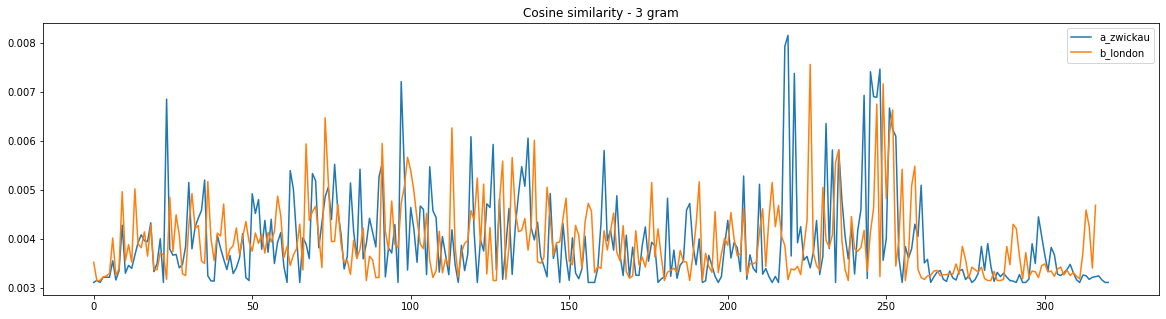

In [91]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(a_zwickau_cosine_similarities_average, label="a_zwickau")
ax.plot(b_london_cosine_similarities_average, label="b_london")
ax.legend()
plt.title('Cosine similarity - 3 gram'.format(param))
plt.show()

In [92]:
a_zwickau_cosine_similarities = calculate_cosine_similarities(a_zwickau_4_gram_freq)
b_london_cosine_similarities = calculate_cosine_similarities(b_london_4_gram_freq)

a_zwickau_cosine_similarities_average = calculate_cosine_similarities_average(a_zwickau_cosine_similarities)
b_london_cosine_similarities_average = calculate_cosine_similarities_average(b_london_cosine_similarities)

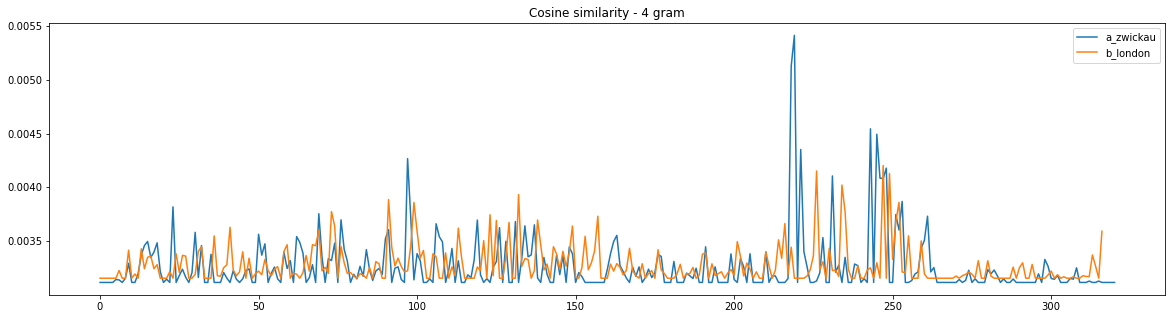

In [93]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(a_zwickau_cosine_similarities_average, label="a_zwickau")
ax.plot(b_london_cosine_similarities_average, label="b_london")
ax.legend()
plt.title('Cosine similarity - 4 gram'.format(param))
plt.show()

In [94]:
# this code been takken from practical natural language provessing
# and used to clean up punctuation, nubmers and englist stop words

from nltk.corpus import stopwords
from string import punctuation

def preprocess_corpus(texts):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
#         return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit() and token not in punctuation]
        return [token.lower() for token in tokens if token not token.isdigit() and token not in punctuation]
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

SyntaxError: invalid syntax (<ipython-input-94-d4371e206ce6>, line 11)

In [10]:
from cltk.data.fetch import FetchCorpus
corpus_downloader = FetchCorpus(language="lat")
print(corpus_downloader.list_corpora)
corpus_downloader.import_corpus("lat_models_cltk")

['lat_text_perseus', 'lat_treebank_perseus', 'lat_text_latin_library', 'phi5', 'phi7', 'latin_proper_names_cltk', 'lat_models_cltk', 'latin_pos_lemmata_cltk', 'latin_treebank_index_thomisticus', 'latin_lexica_perseus', 'latin_training_set_sentence_cltk', 'latin_word2vec_cltk', 'latin_text_antique_digiliblt', 'latin_text_corpus_grammaticorum_latinorum', 'latin_text_poeti_ditalia', 'lat_text_tesserae', 'cltk_lat_lewis_elementary_lexicon']


In [42]:
"super terram exaltate et sic  eis qualitercumque complanetis alia".replace("  ", " ")

'super terram exaltate et sic eis qualitercumque complanetis alia'

cltk.lemmatize.lat.LatinBackoffLemmatizer

In [54]:
lemmatize("super terram exaltate et sic eis qualitercumque complanetis alia".split(" "))


[('super', 'super'),
 ('terram', 'terra'),
 ('exaltate', 'exaltas'),
 ('et', 'et'),
 ('sic', 'sic'),
 ('eis', 'is'),
 ('qualitercumque', 'qualis'),
 ('complanetis', 'complanetis'),
 ('alia', 'alius')]

In [60]:
len(create_lemmatized_tokens("super terram terra exaltate et sic eis qualitercumque complanetis alia".split(" ")))

9

In [50]:
{"apple", "banana", "cherry", "apple"}

{'apple', 'banana', 'cherry'}

In [51]:
set(["apple", "banana", "cherry", "apple"])

{'apple', 'banana', 'cherry'}